### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import os
from typing import List, Tuple
from pprint import pprint
import pandas as pd
from datetime import date
import random
from dotenv import load_dotenv
load_dotenv(verbose=True)
plt.rcParams["figure.figsize"] = (15,15)

### Define Constants

The numbers with regard to debt/salary/etc are MADE UP for demonstration purposes. 

In [2]:
TARGET_INFLATION = 1.02 # Target of 2%
EXPECTED_INTEREST = 1.05 # 5% = 2% PRI + 3
MAX_YEARS = 30 # loan gets wiped
THRESHOLD_PAYMENT = 26_575 # TODO: might be subject to inflation

TOTAL_DEBT = float(os.environ.get('TOTAL_DEBT') or input("Enter your total debt in £"))
BASE_SALARY = float(os.environ.get('BASE_SALARY') or input("Enter your base salary in £"))
SALARY_INCREASE = 1 + float(os.environ.get('PERCENTAGE_SALARY_INCREASE') or input("Enter your % salary increase per year")) / 100
SALARY_EXPECTATIONS = [BASE_SALARY * (SALARY_INCREASE ** year) for year in range(MAX_YEARS)]
MINIMUM_PAYMENTS = [(salary - THRESHOLD_PAYMENT) * 0.09 for salary in SALARY_EXPECTATIONS] # 9% of salary past beyond the threshold

In [3]:
print(f"Attempting to pay off £{TOTAL_DEBT} with initial salary of £{BASE_SALARY}. The salary is projected to increase by a factor {SALARY_INCREASE}.")

Attempting to pay off £59352.95 with initial salary of £40000.0. The salary is projected to increase by a factor 1.03


### Calculate

In [4]:
def calculate_debt(
    payments: List,
    interests: List=None,
) -> Tuple[List, float]:
    """ accepts a list of yearly payments, returns a list of yearly remaining debt and the total paid"""
    assert len(payments) == MAX_YEARS

    debt_remaining = TOTAL_DEBT
    yearly_remaining = []
    total_paid = 0
    for i in range(MAX_YEARS):
        yearly_remaining.append(debt_remaining)
        
        if debt_remaining == 0:
            continue
        
        # pay down debt
        total_paid += payments[i]
        debt_remaining = max(debt_remaining - payments[i], 0)
        
        interest = EXPECTED_INTEREST if interests is None else random.choice(interests)

        # add interest
        debt_remaining = debt_remaining * interest

    return yearly_remaining, total_paid

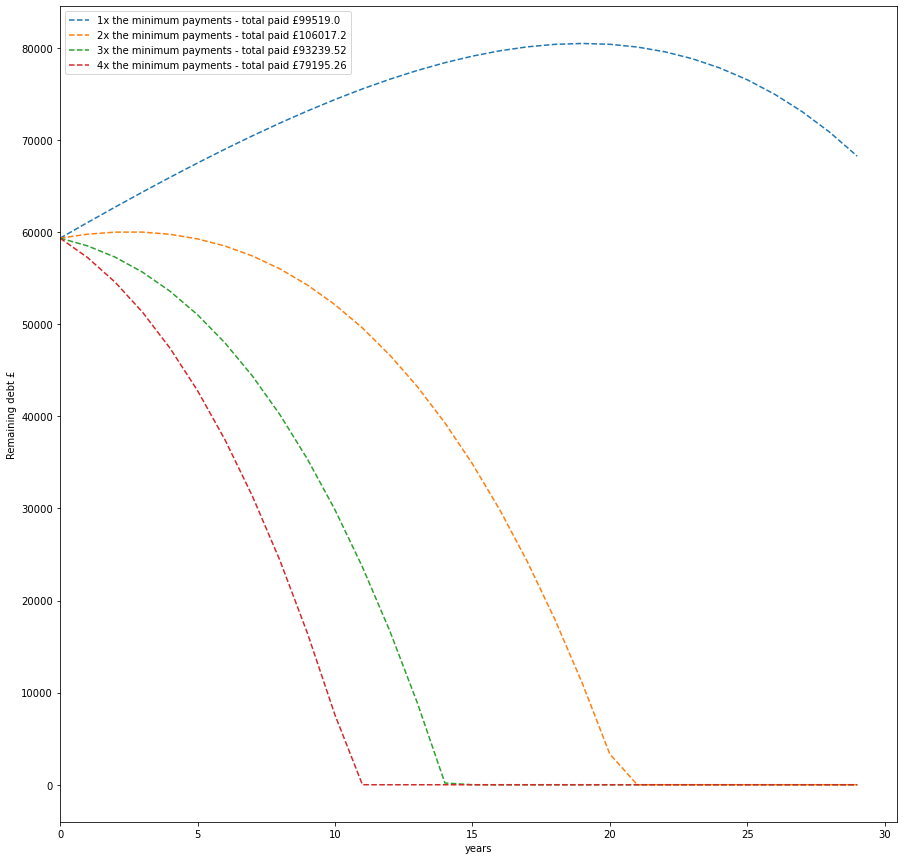

In [5]:
for n_times_minimum in range(1, 5):
    debt_over_time, total_paid = calculate_debt(list(map(lambda x: x * n_times_minimum, MINIMUM_PAYMENTS)))
    plt.plot(debt_over_time, 
             label=str(f"{n_times_minimum}x the minimum payments - total paid £{round(total_paid, 2)}"), 
             linestyle="dashed")
    
plt.legend()
plt.xlabel("years")
plt.xlim(0, None)
plt.ylabel("Remaining debt £")
plt.show()

In [6]:
df = pd.read_csv("cpi.csv", infer_datetime_format=True)
print(df)
print(df.dtypes)

         Date  CPI  CPIH  RPI
0    2003 DEC  1.3   1.3  2.8
1    2004 JAN  1.4   1.5  2.6
2    2004 FEB  1.3   1.4  2.5
3    2004 MAR  1.1   1.2  2.6
4    2004 APR  1.1   1.1  2.5
..        ...  ...   ...  ...
198  2020 JUN  0.6   0.8  1.1
199  2020 JUL  1.0   1.1  1.6
200  2020 AUG  0.2   0.5  0.5
201  2020 SEP  0.5   0.7  1.1
202  2020 OCT  0.7   0.9  1.3

[203 rows x 4 columns]
Date     object
CPI     float64
CPIH    float64
RPI     float64
dtype: object


In [7]:
def datetime_parse(date_str: str) -> date:
    """ Parse datetime """
    year, month = date_str.split()
    year = int(year)
    month = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'].index(month) + 1
    return date(year, month, 1)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
print(df)
print(df.index)

            CPI  CPIH  RPI
Date                      
2003-12-01  1.3   1.3  2.8
2004-01-01  1.4   1.5  2.6
2004-02-01  1.3   1.4  2.5
2004-03-01  1.1   1.2  2.6
2004-04-01  1.1   1.1  2.5
...         ...   ...  ...
2020-06-01  0.6   0.8  1.1
2020-07-01  1.0   1.1  1.6
2020-08-01  0.2   0.5  0.5
2020-09-01  0.5   0.7  1.1
2020-10-01  0.7   0.9  1.3

[203 rows x 3 columns]
DatetimeIndex(['2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01',
               '2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01',
               '2004-08-01', '2004-09-01',
               ...
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='Date', length=203, freq=None)


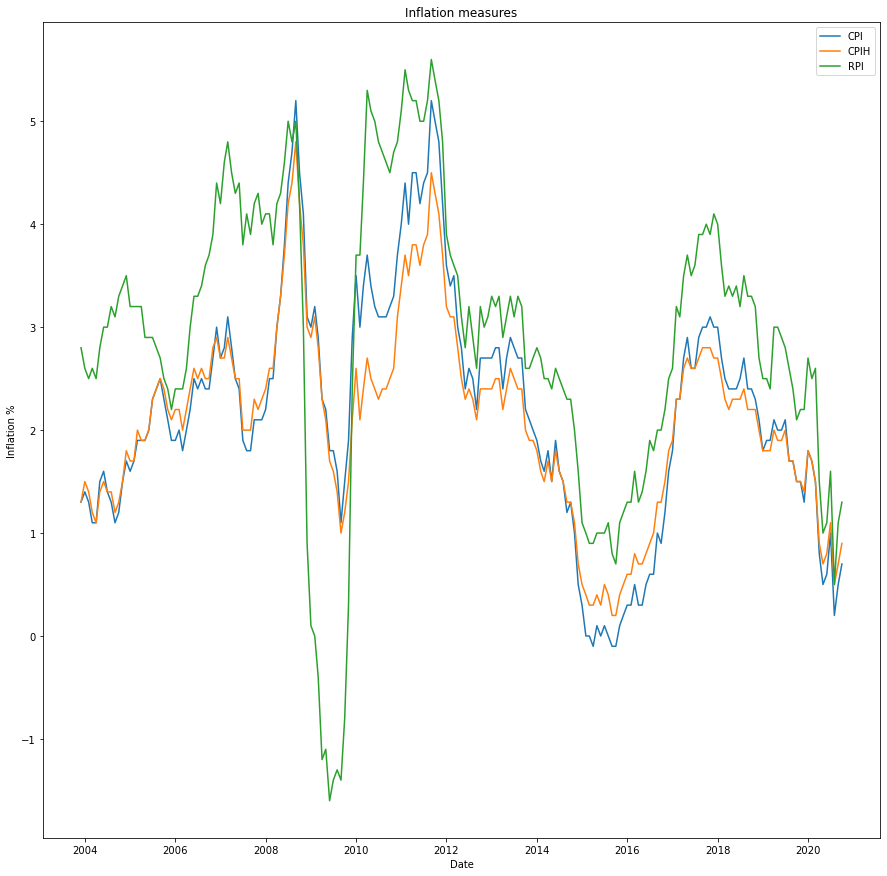

In [8]:
for col in ['CPI', 'CPIH', 'RPI']:
    plt.plot(df.index, df[col], label=col)

plt.ylabel("Inflation %")
plt.xlabel("Date")
plt.title("Inflation measures")
plt.legend()
plt.show()

### RPI calculation from every March

In [9]:
mean = df['RPI'][df.index.month == 3].mean()
mad = df['RPI'][df.index.month == 3].mad()
print(f"Mean: {mean} MAD: {mad}")

Mean: 2.905882352941177 MAD: 1.0173010380622838


### Get interest rates to sample from

In [10]:
interests = (df['RPI'] / 100 + 1.03).clip(lower=1).to_numpy()
print(interests)

[1.058 1.056 1.055 1.056 1.055 1.058 1.06  1.06  1.062 1.061 1.063 1.064
 1.065 1.062 1.062 1.062 1.062 1.059 1.059 1.059 1.058 1.057 1.055 1.054
 1.052 1.054 1.054 1.054 1.056 1.06  1.063 1.063 1.064 1.066 1.067 1.069
 1.074 1.072 1.076 1.078 1.075 1.073 1.074 1.068 1.071 1.069 1.072 1.073
 1.07  1.071 1.071 1.068 1.072 1.073 1.076 1.08  1.078 1.08  1.072 1.06
 1.039 1.031 1.03  1.026 1.018 1.019 1.014 1.016 1.017 1.016 1.022 1.033
 1.054 1.067 1.067 1.074 1.083 1.081 1.08  1.078 1.077 1.076 1.075 1.077
 1.078 1.081 1.085 1.083 1.082 1.082 1.08  1.08  1.082 1.086 1.084 1.082
 1.078 1.069 1.067 1.066 1.065 1.061 1.058 1.062 1.059 1.056 1.062 1.06
 1.061 1.063 1.062 1.063 1.059 1.061 1.063 1.061 1.063 1.062 1.056 1.056
 1.057 1.058 1.057 1.055 1.055 1.054 1.056 1.055 1.054 1.053 1.053 1.05
 1.046 1.041 1.04  1.039 1.039 1.04  1.04  1.04  1.041 1.038 1.037 1.041
 1.042 1.043 1.043 1.046 1.043 1.044 1.046 1.049 1.048 1.05  1.05  1.052
 1.055 1.056 1.062 1.061 1.065 1.067 1.065 1.066 1.069

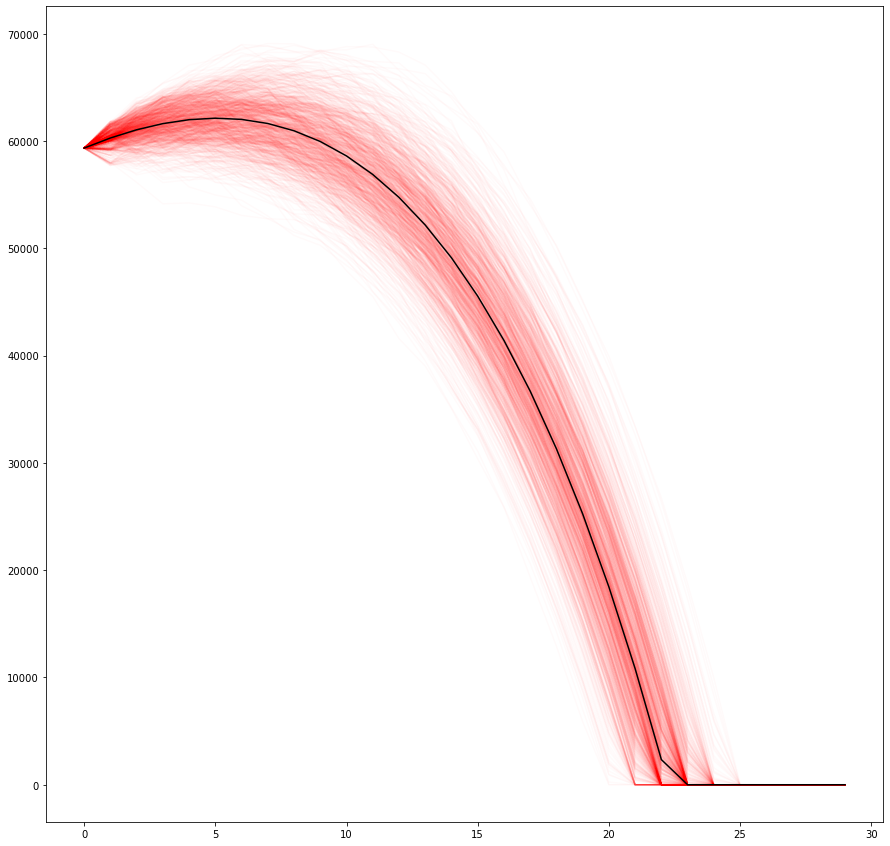

In [16]:
for _ in range(1000):
    debt_over_time, total_paid = calculate_debt(list(map(lambda x: x * 2, MINIMUM_PAYMENTS)), interests=interests)
    plt.plot(debt_over_time, alpha=0.02, c='red')

debt_over_time, total_paid = calculate_debt(list(map(lambda x: x * 2, MINIMUM_PAYMENTS)), interests=[interests.mean()])
plt.plot(debt_over_time, c='black')

plt.show()


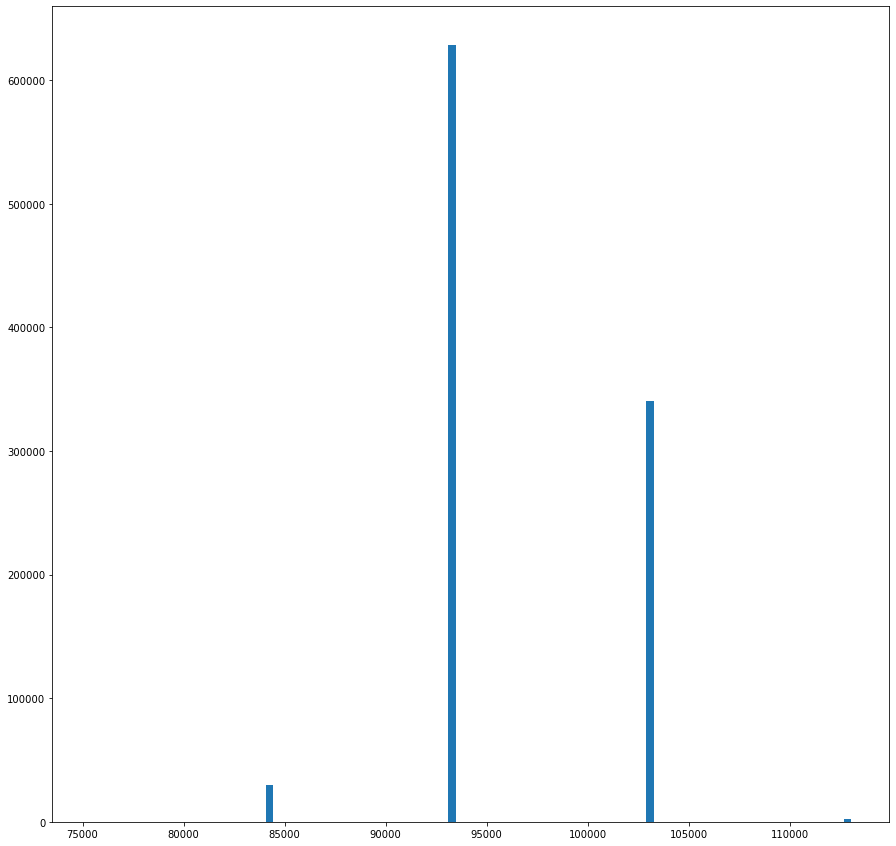

In [30]:
for n_times_minimum in [3]:
    total_paid_samples = []
    for _ in range(1000000):
        total_paid_samples.append(
            calculate_debt(list(map(lambda x: x * n_times_minimum, MINIMUM_PAYMENTS)), interests=interests)[1]
        )
    plt.hist(total_paid_samples, bins=100)
    plt.show()


In [26]:
set(total_paid_samples)

{10, 11}